In [1]:
!pip install torchvision


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [5]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [6]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0
    correct = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    train_loss = train_loss / len(dataloader)
    train_accuracy = correct / size
    return train_loss, train_accuracy

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    test_accuracy = correct / size
    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, test_accuracy

In [10]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [11]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    train_loss, train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    val_loss, val_accuracy = test(test_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

print("Done!")

Epoch 1
-------------------------------
loss: 2.302508  [   64/60000]
loss: 2.288335  [ 6464/60000]
loss: 2.264716  [12864/60000]
loss: 2.260619  [19264/60000]
loss: 2.250947  [25664/60000]
loss: 2.206677  [32064/60000]
loss: 2.232838  [38464/60000]
loss: 2.191527  [44864/60000]
loss: 2.188026  [51264/60000]
loss: 2.154475  [57664/60000]
Test Error: 
 Accuracy: 28.4%, Avg loss: 2.149196 

Epoch 2
-------------------------------
loss: 2.156047  [   64/60000]
loss: 2.144649  [ 6464/60000]
loss: 2.088042  [12864/60000]
loss: 2.113847  [19264/60000]
loss: 2.047404  [25664/60000]
loss: 1.983492  [32064/60000]
loss: 2.024318  [38464/60000]
loss: 1.939742  [44864/60000]
loss: 1.947964  [51264/60000]
loss: 1.878621  [57664/60000]
Test Error: 
 Accuracy: 50.2%, Avg loss: 1.875352 

Epoch 3
-------------------------------
loss: 1.897611  [   64/60000]
loss: 1.869656  [ 6464/60000]
loss: 1.760123  [12864/60000]
loss: 1.817036  [19264/60000]
loss: 1.678373  [25664/60000]
loss: 1.635555  [32064/600

#### Training and Validation Loss curves

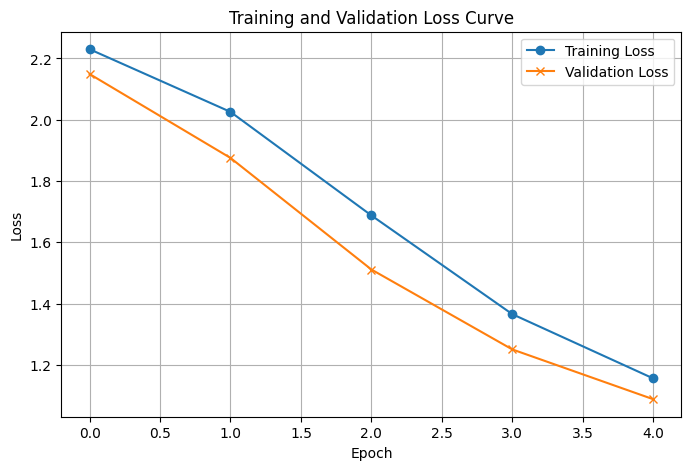

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

#### Training and validation accuracy curves

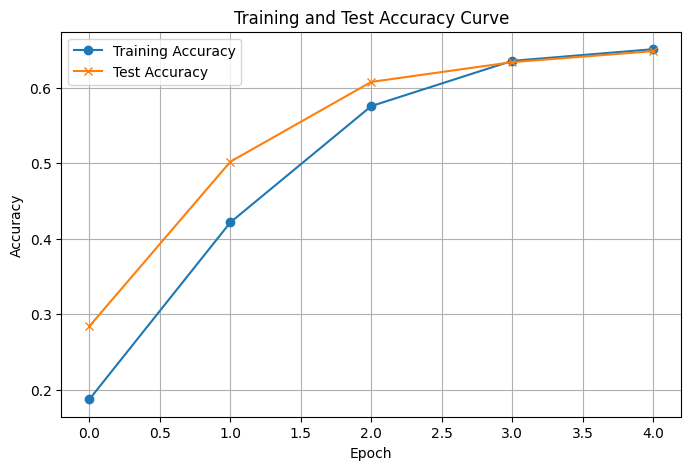

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Test Accuracy', marker = 'x')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [16]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#### Trying a different loss function

I am trying Negative Loss likehood function (NLLLoss). To use this loss function, the outputs of the model should be log probabilities. so, separate softmax activation should be applied to the model's output.

In [19]:
import torch.nn.functional as F

class SecondNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return F.log_softmax(logits, dim=1)

In [20]:
second_model = SecondNeuralNetwork().to(device)
print(second_model)

SecondNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [21]:
second_loss_fn = torch.nn.NLLLoss()
second_optimizer = torch.optim.SGD(second_model.parameters(), lr=1e-3)

In [22]:
second_train_losses = []
second_train_accuracies = []
second_val_losses = []
second_val_accuracies = []

In [23]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(train_dataloader, second_model, second_loss_fn, second_optimizer)
    val_loss, val_accuracy = test(test_dataloader, second_model, second_loss_fn)
    second_train_losses.append(train_loss)
    second_train_accuracies.append(train_accuracy)
    second_val_losses.append(val_loss)
    second_val_accuracies.append(val_accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310903  [   64/60000]
loss: 2.289613  [ 6464/60000]
loss: 2.269010  [12864/60000]
loss: 2.263839  [19264/60000]
loss: 2.248420  [25664/60000]
loss: 2.208748  [32064/60000]
loss: 2.228056  [38464/60000]
loss: 2.183578  [44864/60000]
loss: 2.188411  [51264/60000]
loss: 2.149299  [57664/60000]
Test Error: 
 Accuracy: 41.5%, Avg loss: 2.141160 

Epoch 2
-------------------------------
loss: 2.167522  [   64/60000]
loss: 2.142222  [ 6464/60000]
loss: 2.080881  [12864/60000]
loss: 2.094738  [19264/60000]
loss: 2.053452  [25664/60000]
loss: 1.980747  [32064/60000]
loss: 2.015170  [38464/60000]
loss: 1.926560  [44864/60000]
loss: 1.933506  [51264/60000]
loss: 1.850505  [57664/60000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.855060 

Epoch 3
-------------------------------
loss: 1.904079  [   64/60000]
loss: 1.859132  [ 6464/60000]
loss: 1.738002  [12864/60000]
loss: 1.774683  [19264/60000]
loss: 1.688735  [25664/60000]
loss: 1.626230  [32064/600

In [24]:
torch.save(second_model.state_dict(), "second_model.pth")
print("Saved PyTorch Model State to second_model.pth")

Saved PyTorch Model State to second_model.pth


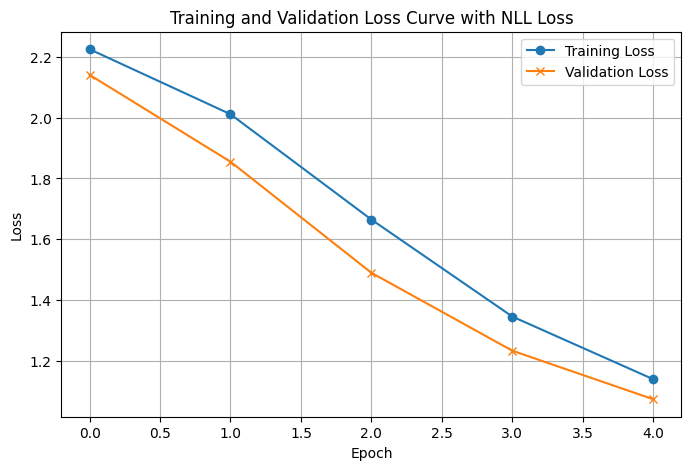

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(second_train_losses, label='Training Loss', marker='o')
plt.plot(second_val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve with NLL Loss')
plt.legend()
plt.grid(True)
plt.show()

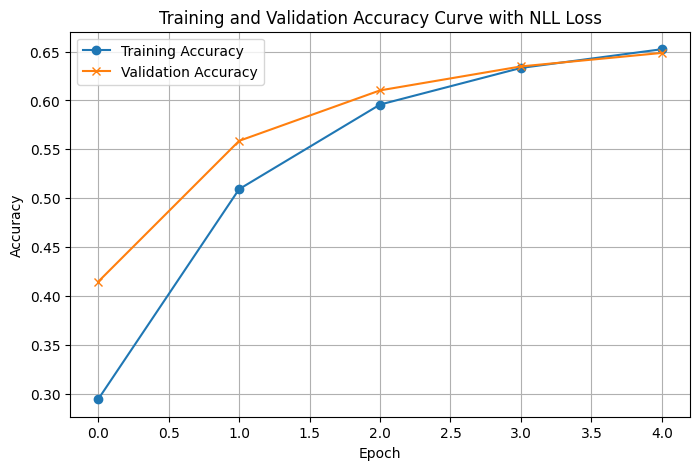

In [26]:
plt.figure(figsize=(8, 5))
plt.plot(second_train_accuracies, label='Training Accuracy', marker='o')
plt.plot(second_val_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve with NLL Loss')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
second_model = SecondNeuralNetwork().to(device)
second_model.load_state_dict(torch.load("second_model.pth", weights_only=True))

<All keys matched successfully>

In [28]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

second_model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = second_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#### An analysis of the training/validation loss : Cross Entropy Loss and Negative Log-likelihood Loss

| Epoch | Cross Entropy Loss | Cross entropy (Accuracy) | NLL Loss | NLL (Accuracy) |
|-------|----------------|--------------------|------------------|---------------------|
| 1     | 2.149          | 28.4%              | 2.141            | 41.5%               |
| 2     | 1.909          | 45.6%              | 1.855            | 55.9%               |
| 3     | 1.695          | 52.9%              | 1.489            | 61.0%               |
| 4     | 1.413          | 61.3%              | 1.233            | 63.5%               |
| 5     | 1.087          | 64.9%              | 1.073            | 64.9%               |

Though NLL Loss started with better accuracy, cross entropy showed faster convergence than NLL Loss. Both the loss functions has almost the same validation loss at the end of 5th epoch. But, Cross entropy is the common loss function used for multi-class classification problems. NLLLoss requires the model's outputs to be log probabilities. But, cross entropy compute the probabilities internally. so, it provides more numerical stability compated to NLL Loss.

#### CNN model with a single CNN layer and 3x3 filter

In [29]:
import torch.nn.functional as F

class OneLayerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)  
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(16 * 26 * 26, 10)

    def forward(self, x):
        x = self.conv1(x)             
        x = F.relu(x)                 
        x = self.flatten(x)          
        x = self.fc(x)           
        return x

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
cnn_model = OneLayerCNN().to(device)
print(cnn_model)

cpu
OneLayerCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=10816, out_features=10, bias=True)
)


In [31]:
cnn_loss_fn = nn.CrossEntropyLoss()
cnn_optimizer = torch.optim.SGD(cnn_model.parameters(), lr=1e-3)

In [32]:
cnn_train_losses = []
cnn_train_accuracies = []
cnn_val_losses = []
cnn_val_accuracies = []

In [33]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(train_dataloader, cnn_model, cnn_loss_fn, cnn_optimizer)
    val_loss, val_accuracy = test(test_dataloader, cnn_model, cnn_loss_fn)
    cnn_train_losses.append(train_loss)
    cnn_train_accuracies.append(train_accuracy)
    cnn_val_losses.append(val_loss)
    cnn_val_accuracies.append(val_accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.310431  [   64/60000]
loss: 1.842070  [ 6464/60000]
loss: 1.395969  [12864/60000]
loss: 1.309009  [19264/60000]
loss: 1.006820  [25664/60000]
loss: 0.959685  [32064/60000]
loss: 0.942144  [38464/60000]
loss: 0.820051  [44864/60000]
loss: 0.858332  [51264/60000]
loss: 0.829303  [57664/60000]
Test Error: 
 Accuracy: 74.6%, Avg loss: 0.768522 

Epoch 2
-------------------------------
loss: 0.728192  [   64/60000]
loss: 0.806559  [ 6464/60000]
loss: 0.547804  [12864/60000]
loss: 0.833970  [19264/60000]
loss: 0.705368  [25664/60000]
loss: 0.707609  [32064/60000]
loss: 0.744941  [38464/60000]
loss: 0.679641  [44864/60000]
loss: 0.733323  [51264/60000]
loss: 0.700966  [57664/60000]
Test Error: 
 Accuracy: 77.2%, Avg loss: 0.653710 

Epoch 3
-------------------------------
loss: 0.577239  [   64/60000]
loss: 0.689956  [ 6464/60000]
loss: 0.448904  [12864/60000]
loss: 0.739129  [19264/60000]
loss: 0.638372  [25664/60000]
loss: 0.640822  [32064/600

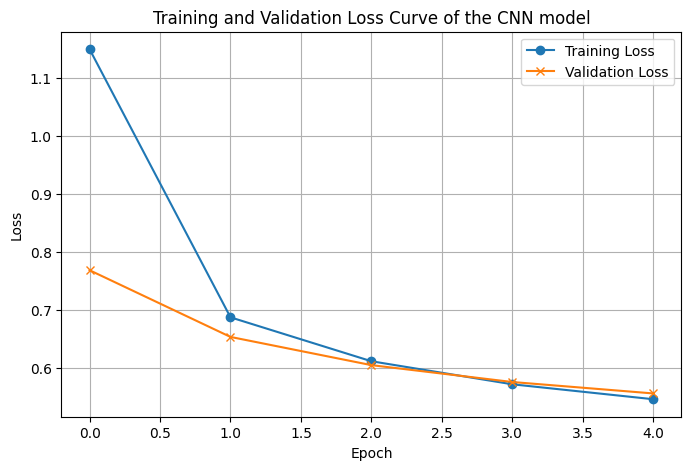

In [35]:
plt.figure(figsize=(8, 5))
plt.plot(cnn_train_losses, label='Training Loss', marker='o')
plt.plot(cnn_val_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve of the CNN model')
plt.legend()
plt.grid(True)
plt.show()

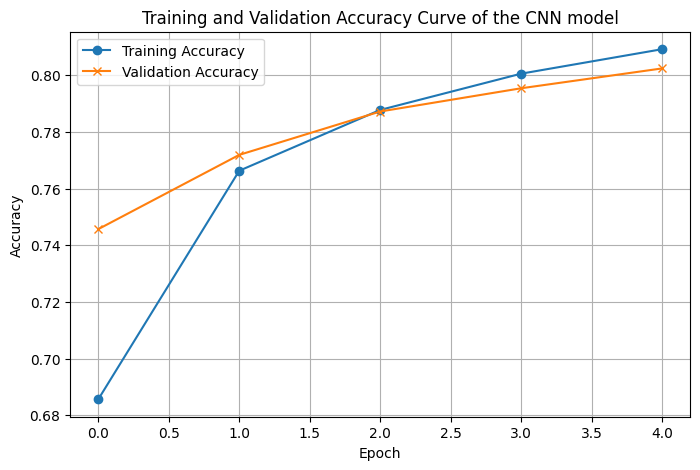

In [36]:
plt.figure(figsize=(8, 5))
plt.plot(cnn_train_accuracies, label='Training Accuracy', marker='o')
plt.plot(cnn_val_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curve of the CNN model')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
torch.save(cnn_model.state_dict(), "cnn_model.pth")
print("Saved PyTorch Model State to cnn_model.pth")

Saved PyTorch Model State to cnn_model.pth


In [38]:
cnn_model = OneLayerCNN().to(device)
cnn_model.load_state_dict(torch.load("cnn_model.pth", weights_only=True))

<All keys matched successfully>

In [39]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

cnn_model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.unsqueeze(0).to(device)
    pred = cnn_model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


#### Compare and Contrast the Single layer CNN model and DNN Model

| **Epoch** | **CNN - Loss** | **CNN - Accuracy** | **DNN - Loss** | **DNN - Accuracy** |
|-----------|----------------|--------------------|----------------|--------------------|
| **1**     | 2.3104         | 74.6%              | 2.3025         | 28.4%              |
| **2**     | 0.7282         | 77.2%              | 2.1560         | 50.2%              |
| **3**     | 0.5772         | 78.7%              | 1.8976         | 60.8%              |
| **4**     | 0.5156         | 79.5%              | 1.5680         | 63.4%              |
| **5**     | 0.4794         | 80.2%              | 1.3219         | 64.9%              |

##### Key Insights:
- The CNN has lower loss and higher accuracy at each epoch compared to the DNN.
- The DNN starts with poor accuracy (28.4%) and gradually improves but was always lower than CNN's accuracy.
- The CNN achieves a higher accuracy of 80.2% at Epoch 5, while the DNN reaches 64.9%.
- The CNN also maintains lower loss values throughout the epochs, starting at 0.768 and reaching 0.556, while the DNN's loss decreases more slowly, from 2.149 to 1.087.

##### Conclusions:
 - For Image Classification tasks, CNNs outperform DNNs as they can exploit spatial patterns. In contrast, DNNs are suited for the tasks where the data is more abstract like tabular data, as they lack the ability to capture local spatial correlations found in image data.
 - CNN converges faster when compared to DNN (with the same loss function, optimizer and the learning rate).